In [1]:
import os
import logging
import glob

from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import webdataset as wds
import matplotlib.pyplot as plt

import net.preprocessing as preprocessing
import net.net as net
import net.io as io
import gfs.fetch
import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_columns', None)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [4]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [5]:
col_names = gfs.fetch.get_col_order()

references = (
    (6, 3),
    (12, 0),
    (12, 3)
)
col_names_full = []
for run, delta in references:
    for col in col_names:
        col_names_full.append(f'{col}_{run+delta}')

In [6]:
# Compute scaling parameters in database for weather features
query = f"""
WITH stats AS (
    SELECT 
        {', '.join(f'AVG({col}) as mean_{col}, STDDEV({col}) as std_{col}' for col in col_names_full)}
    FROM glideator_fs.features_with_target
    WHERE is_validation = FALSE
)
SELECT * FROM stats
"""
stats_df = pd.read_sql(query, engine)

# Create scaling params dictionary for weather features
scaling_params = {}
for col in col_names_full:
    scaling_params[col] = {
        'mean': float(stats_df[f'mean_{col}'].iloc[0]),
        'std': float(stats_df[f'std_{col}'].iloc[0])
    }

# Compute scaling parameters for site features
site_query = """
WITH stats AS (
    SELECT 
        AVG(latitude) as mean_latitude, STDDEV(latitude) as std_latitude,
        AVG(longitude) as mean_longitude, STDDEV(longitude) as std_longitude,
        AVG(altitude) as mean_altitude, STDDEV(altitude) as std_altitude
    FROM glideator_fs.features_with_target
    WHERE is_validation = FALSE
)
SELECT * FROM stats
"""
site_stats_df = pd.read_sql(site_query, engine)

# Create scaling params dictionary for site features
site_scaling_params = {}
for col in ['latitude', 'longitude', 'altitude']:
    site_scaling_params[col] = {
        'mean': float(site_stats_df[f'mean_{col}'].iloc[0]),
        'std': float(site_stats_df[f'std_{col}'].iloc[0])
    }

# Initialize the layers
weather_scaler = net.StandardScalerLayer(scaling_params)
site_scaler = net.StandardScalerLayer(site_scaling_params)

In [7]:
def create_dataloaders(train_path, val_path, batch_size=32, num_workers=4):
    """
    Create train and validation DataLoaders from WebDataset files.
    
    Args:
        train_path (str): Path to training data directory containing .tar files
        val_path (str): Path to validation data directory containing .tar files
        batch_size (int): Batch size for DataLoaders
        num_workers (int): Number of worker processes for data loading
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    # Define pipeline for both datasets
    def create_pipeline(path):
        # Create dataset from .tar files with correct shard formatting
        shards = glob.glob(f"{path}/*.tar")  # Get list of all .tar files in path
        dataset = (
            wds.WebDataset(shards)  # Use explicit shard pattern
            .shuffle(1000)  # Shuffle with a buffer of 1000 samples
            .decode()  # Decode the compressed data
            .to_tuple("features.pth", "targets.pth", "date.pth")  # Extract the tensors we want
        )
        
        # Create DataLoader
        loader = wds.WebLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            persistent_workers=True,
            shuffle=False,  # WebDataset handles shuffling internally
        )
        
        # Make the loader reusable
        loader.length = float('inf')  # Allow multiple epochs
        
        return loader
    
    # Create train and validation loaders
    train_loader = create_pipeline(train_path)
    val_loader = create_pipeline(val_path)
    
    return train_loader, val_loader

In [8]:
train_loader, val_loader = create_dataloaders(
    train_path="training/train_data",
    val_path="training/val_data",
    batch_size=512,
    num_workers=2
)

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [9]:
def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader, 
    val_loader, 
    num_epochs=100,
    checkpoint_path='model_checkpoint.pth',
    l1_lambda=1e-9,
    l2_lambda=1e-9,
    monotonicity_lambda=1e-9,  # New parameter to control monotonicity penalty
    verbose=True
):
    best_val_loss = float('inf')
    train_avg_losses = []
    val_avg_losses = []
    num_targets = model.num_targets
    
    train_losses_per_target = {i: [] for i in range(num_targets)}
    val_losses_per_target = {i: [] for i in range(num_targets)}

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        epoch_train_losses_per_target = {i: [] for i in range(num_targets)}
        
        for features, targets, _ in train_loader:  # Ignore meta data
            optimizer.zero_grad()
            outputs = model(features)  # features is now a dictionary
            # print(outputs)
            loss = 0
            for i in range(num_targets):
                target_loss = criterion(outputs[:, i], targets[:, i])
                loss += target_loss
                epoch_train_losses_per_target[i].append(target_loss.item())
            
            # Monotonicity penalty - ensure outputs are monotonically decreasing
            if monotonicity_lambda > 0:
                monotonicity_loss = 0
                for i in range(1, num_targets):
                    # Add penalty when constraint is violated: output[i-1] < output[i]
                    violations = torch.relu(outputs[:, i] - outputs[:, i-1])
                    monotonicity_loss += torch.mean(violations)
                loss += monotonicity_lambda * monotonicity_loss
            
            # L1 regularization
            if l1_lambda > 0:
                l1_reg = torch.tensor(0., requires_grad=True)
                for param in model.parameters():
                    l1_reg = l1_reg + torch.norm(param, 1)
                loss = loss + l1_lambda * l1_reg

            # L2 regularization
            if l2_lambda > 0:
                l2_reg = torch.tensor(0., requires_grad=True)
                for param in model.parameters():
                    l2_reg = l2_reg + torch.norm(param, 2)**2
                loss = loss + l2_lambda * l2_reg

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        train_avg_losses.append(avg_train_loss)
        avg_train_losses_per_target = {i: sum(losses) / len(losses) 
                                     for i, losses in epoch_train_losses_per_target.items()}
        
        for i in range(num_targets):
            train_losses_per_target[i].append(avg_train_losses_per_target[i])
        
        # Validation
        model.eval()
        val_losses = []
        epoch_val_losses_per_target = {i: [] for i in range(num_targets)}
        
        with torch.no_grad():
            for features, targets, _ in val_loader:  # Ignore meta data
                outputs = model(features)  # features is now a dictionary
                loss = 0
                for i in range(num_targets):
                    target_loss = criterion(outputs[:, i], targets[:, i])
                    loss += target_loss
                    epoch_val_losses_per_target[i].append(target_loss.item())
                val_losses.append(loss.item())
                
        avg_val_loss = sum(val_losses) / len(val_losses)
        val_avg_losses.append(avg_val_loss)
        avg_val_losses_per_target = {i: sum(losses) / len(losses) 
                                   for i, losses in epoch_val_losses_per_target.items()}
        
        for i in range(num_targets):
            val_losses_per_target[i].append(avg_val_losses_per_target[i])
        
        if verbose:
            logger.info(f"Epoch {epoch+1}/{num_epochs}, "
                       f"Loss: {avg_train_loss:.4f}, "
                       f"Validation Loss: {avg_val_loss:.4f}")
        
        # Model checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, checkpoint_path)
            if verbose:
                logger.info(f"Checkpoint saved at epoch {epoch+1}")
        
        scheduler.step()

    # Load best model
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_train_loss = checkpoint['train_loss']
    best_val_loss = checkpoint['val_loss']

    if verbose:
        logger.info(f"Loaded best model from epoch {best_epoch+1}")
        logger.info(f"Best training loss: {best_train_loss:.4f}")
        logger.info(f"Best validation loss: {best_val_loss:.4f}")

    return {
        'model': model,
        'best_epoch': best_epoch,
        'best_train_loss': best_train_loss,
        'best_val_loss': best_val_loss,
        'train_losses': train_avg_losses,
        'val_losses': val_avg_losses,
        'train_losses_per_target': train_losses_per_target,
        'val_losses_per_target': val_losses_per_target
    }

In [13]:
# Initialize model
model = net.GlideatorNet(
    weather_scaler=weather_scaler,
    site_scaler=site_scaler,
    num_launches=251,  # Get this from your data
    num_targets=11,  # For XC thresholds
    site_embedding_dim=32,
    deep_hidden_units=[128, 64],
    cross_layers=2
)

In [14]:
# Initialize optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.BCELoss()

In [ ]:
# Train model
results = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    l1_lambda=0,
    l2_lambda=0,
    monotonicity_lambda=10,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=300
)

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/autodecode.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

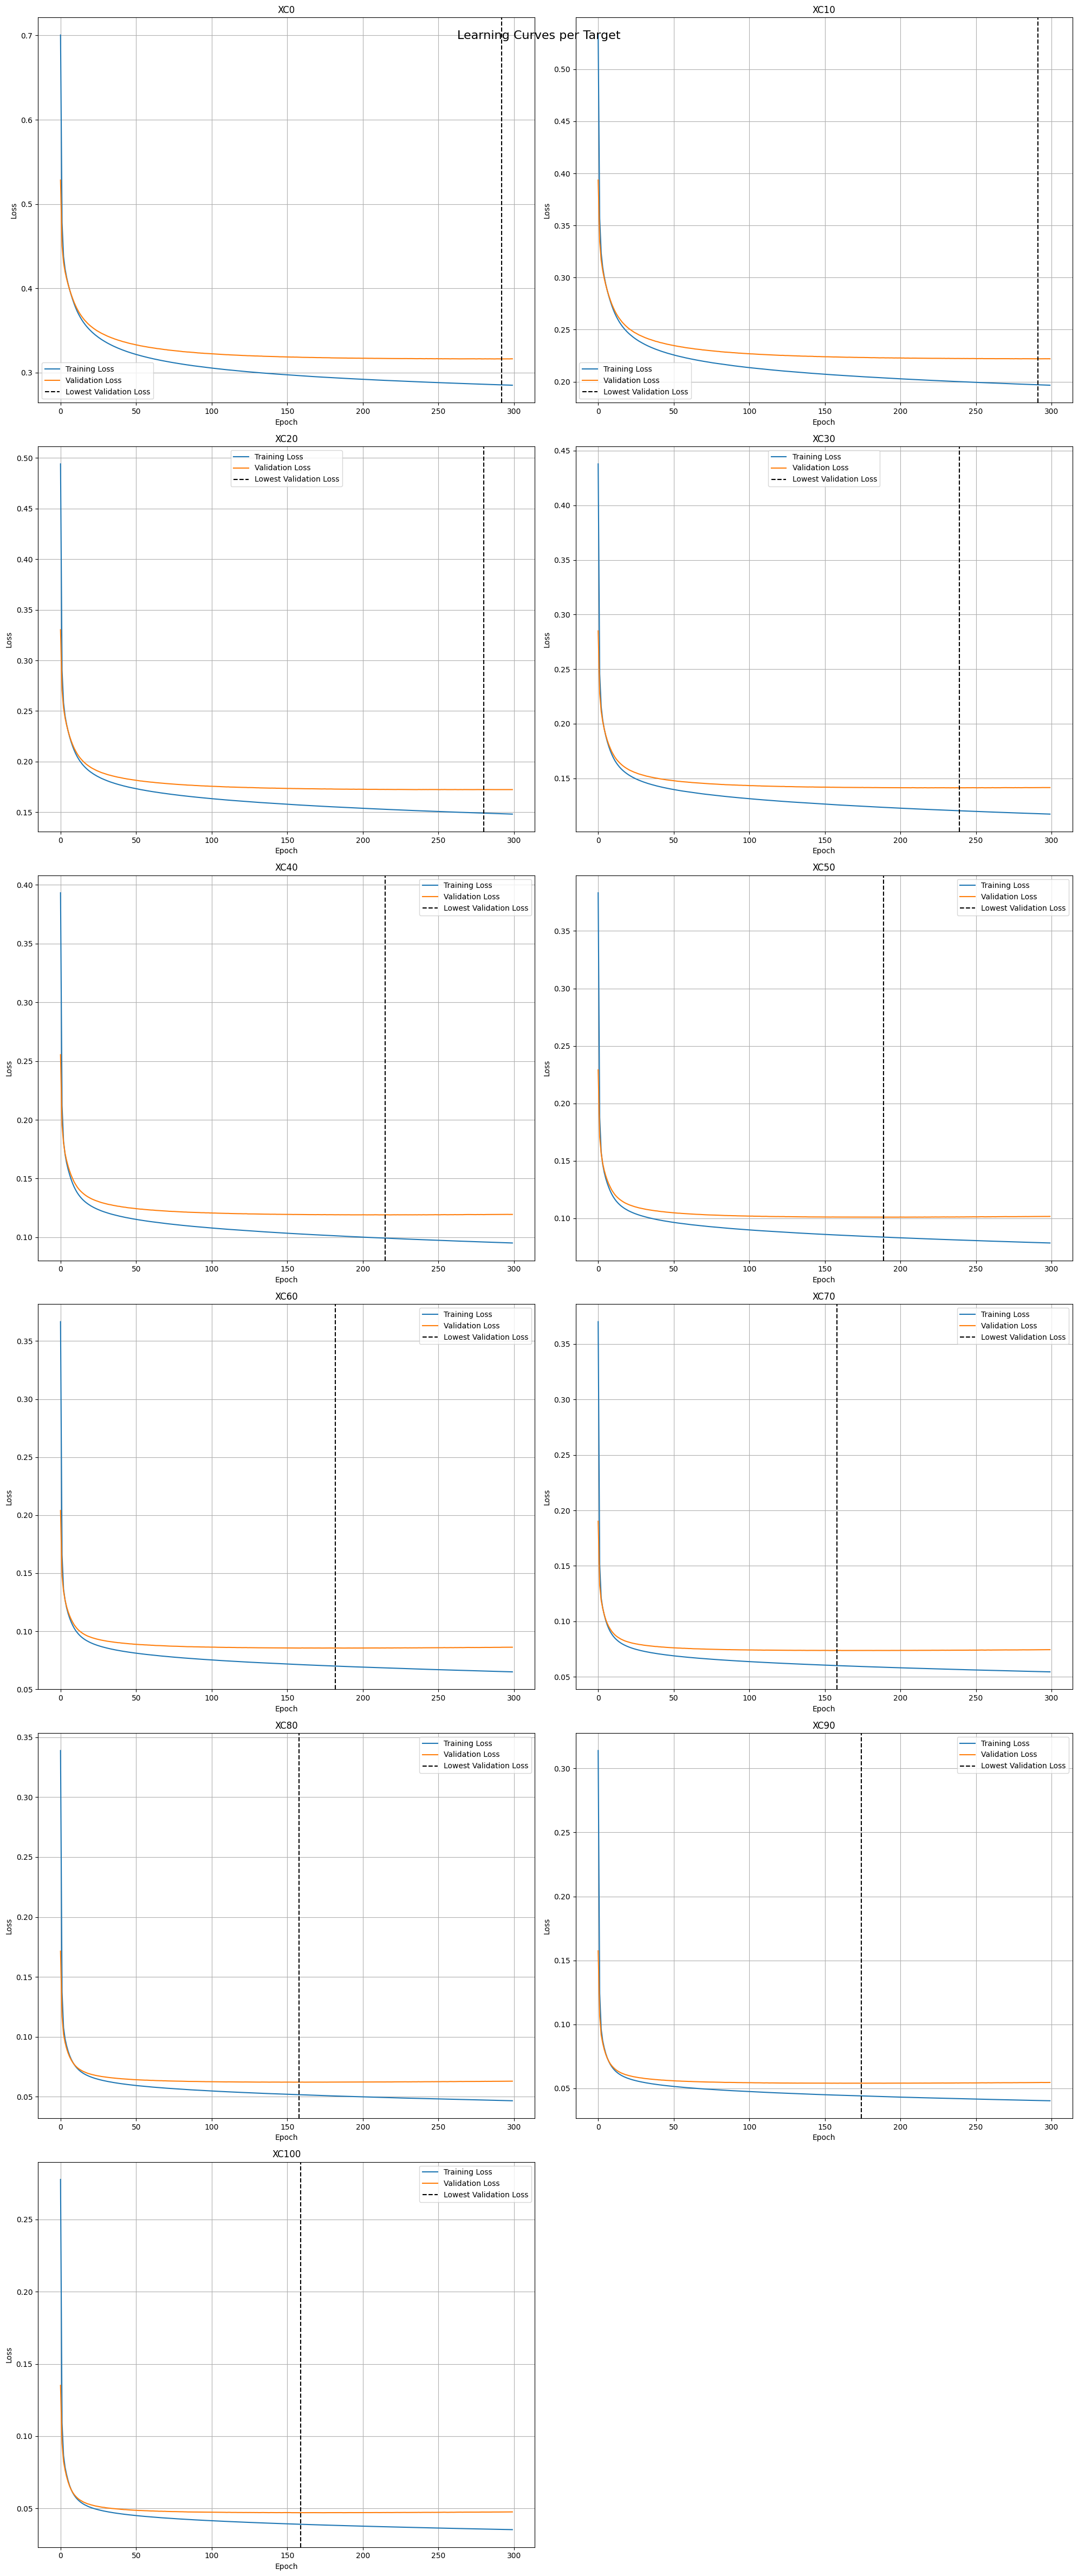

In [16]:
targets = [f'XC{threshold}' for threshold in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]
utils.plot_learning_curves_per_target(results['train_losses_per_target'], results['val_losses_per_target'], targets)

In [17]:
io.save_net(results['model'], 'training/models/model_300_mono_10_reg_0.pth')